<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/ml/clustering_with_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kneed --q

In [2]:
import yfinance as yf

df = yf.download('^nsei','2018-01-01').reset_index()

# Distance from the moving averages
for m in [10, 20, 30, 50, 100]:
    df[f'feat_dist_from_ma_{m}'] = df['Close']/df['Close'].rolling(m).mean()-1

# Distance from n day max/min
for m in [3, 5, 10, 15, 20, 30, 50, 100]:
    df[f'feat_dist_from_max_{m}'] = df['Close']/df['High'].rolling(m).max()-1
    df[f'feat_dist_from_min_{m}'] = df['Close']/df['Low'].rolling(m).min()-1

# Price distance
for m in [1, 2, 3, 4, 5, 10, 15, 20, 30, 50, 100]:
    df[f'feat_price_dist_{m}'] = df['Close']/df['Close'].shift(m)-1

[*********************100%%**********************]  1 of 1 completed


In [3]:
df = df.dropna()
df_train = df[df['Date'] < '2022-01-01'].reset_index(drop=True)
df_test = df[df['Date'] >= '2022-01-01'].reset_index(drop=True)

feat_cols = [col for col in df.columns if 'feat' in col]

## Begin Clustering Efforts

Optimal k: 9


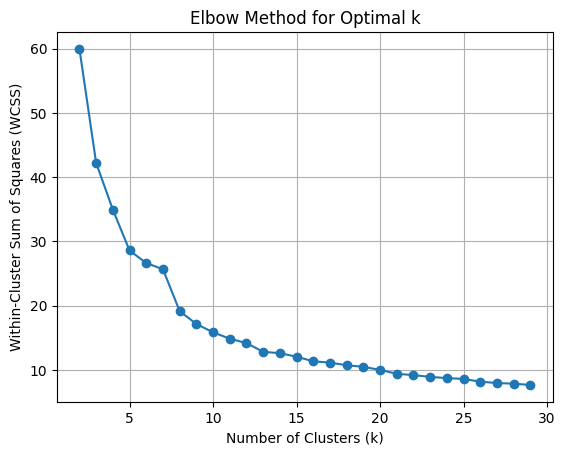

In [4]:
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from kneed import KneeLocator

x_train = df_train[feat_cols]

wcss = []
k_range = range(2, 30)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(x_train)
    wcss.append(kmeans.inertia_)

elbow_locator = KneeLocator(k_range, wcss, curve='convex', direction='decreasing')
optimal_k = elbow_locator.elbow

print(f'Optimal k: {optimal_k}')

plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

optimal_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
optimal_kmeans.fit(x_train)

df_train['cluster'] = optimal_kmeans.predict(x_train)

In [5]:
import plotly.express as px

df_plot = df_train[df_train['Date'] > '2015-01-01']

fig = px.scatter(
    df_plot,
    x='Date',
    y='Close',
    color='cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Training',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

In [18]:
import numpy as np

good_clusters = [1,3,4,6,8]

df_plot['good_cluster'] = np.where(df_plot['cluster'].isin(good_clusters), 1, 0)

fig = px.scatter(
    df_plot,
    x='Date',
    y='Close',
    color='good_cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Training',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

In [7]:
df_test['cluster'] = optimal_kmeans.predict(df_test[feat_cols])

fig = px.scatter(
    df_test,
    x='Date',
    y='Close',
    color='cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Testing-- LOOK FOR BOTTOMS FORMING[ ***SEE * THIS * FOR * TRADING***]',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

In [8]:
import numpy as np

df_test['good_cluster'] = np.where(df_test['cluster'].isin(good_clusters), 1, 0)

fig = px.scatter(
    df_test,
    x='Date',
    y='Close',
    color='good_cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Testing Set',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

## Quick Backtest

In [9]:
from plotly import graph_objects as go

df_test['pct_change'] = df_test['Close'].pct_change()
df_test['signal'] = df_test['good_cluster'].shift(1)

df_test['equity_cluster'] = np.cumprod(1+df_test['signal']*df_test['pct_change'])
df_test['equity_buy_and_hold'] = np.cumprod(1+df_test['pct_change'])

fig = go.Figure()

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_buy_and_hold'], name='Buy and Hold')
)

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_cluster'], name='Clustering')
)

fig.update_layout(
    title_text='Quick Clustering Backtest',
    legend={'x': 0, 'y':-0.05, 'orientation': 'h'},
    xaxis={'title': 'Date'},
    yaxis={'title': 'Multiple from Initial Investment'}
)

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Random Forest Layer

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

x_train = df_train[feat_cols]
y_train = np.where(df_train['cluster'].isin(good_clusters), 1, 0)

x_test = df_test[feat_cols]
y_test = np.where(df_test['cluster'].isin(good_clusters), 1, 0)

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
)

clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# Calculate accuracy and precision for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

# Calculate accuracy and precision for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Training Precision: {train_precision}')
print('')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')

Training Accuracy: 0.997737556561086
Training Precision: 1.0

Test Accuracy: 0.9646182495344506
Test Precision: 0.9748953974895398


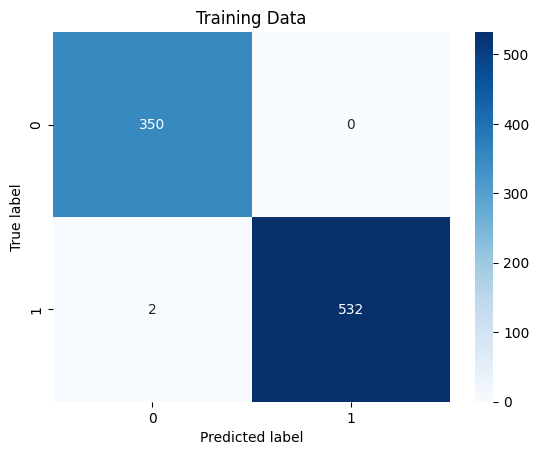

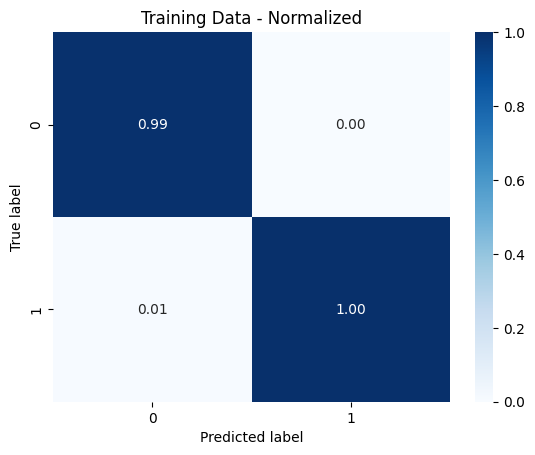

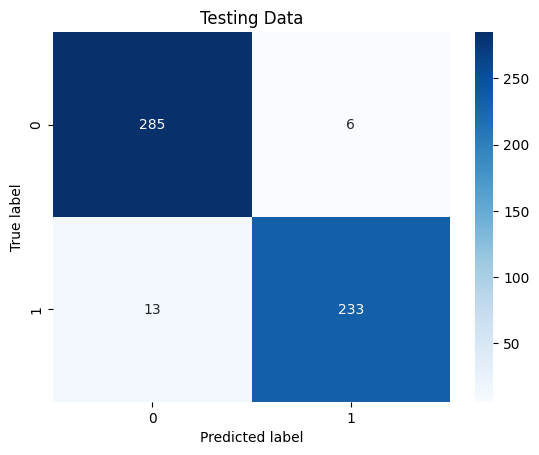

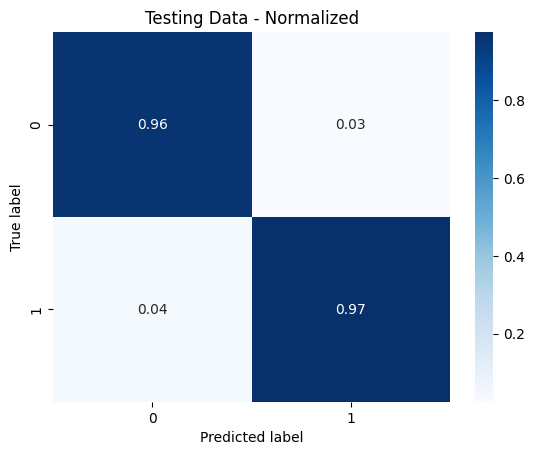

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title, normalize):

    if normalize:
        cm = confusion_matrix(y_true, y_pred, normalize='pred')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    else:
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return

plot_confusion_matrix(y_train, y_train_pred, title='Training Data', normalize=False)
plot_confusion_matrix(y_train, y_train_pred, title='Training Data - Normalized', normalize=True)

plot_confusion_matrix(y_test, y_test_pred, title='Testing Data', normalize=False)
plot_confusion_matrix(y_test, y_test_pred, title='Testing Data - Normalized', normalize=True)

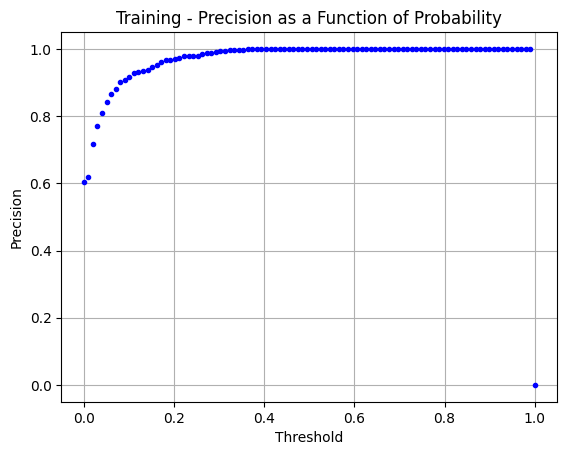

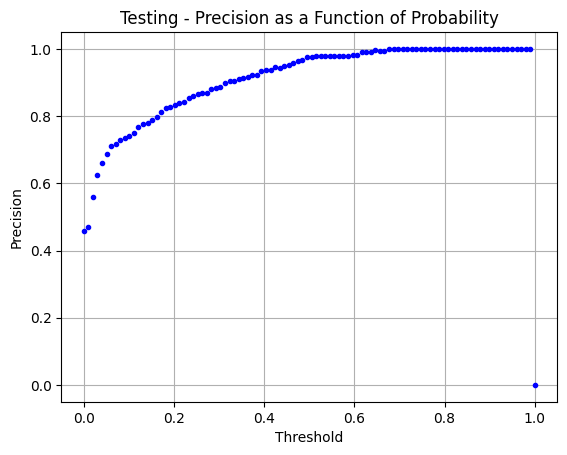

In [12]:
import numpy as np

def get_precision_curve(clf, x, y, title):

    y_scores = clf.predict_proba(x)[:, 1]

    thresholds = np.linspace(0, 1, 100)
    precision = []

    for t in thresholds:
        y_pred_threshold = (y_scores >= t).astype(int)
        precision.append(precision_score(y, y_pred_threshold, zero_division=0))

    plt.plot(thresholds, precision, 'b.')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title(title)
    plt.grid(True)
    plt.show()

    return

get_precision_curve(clf, x_train, y_train, 'Training - Precision as a Function of Probability')
get_precision_curve(clf, x_test, y_test, 'Testing - Precision as a Function of Probability')

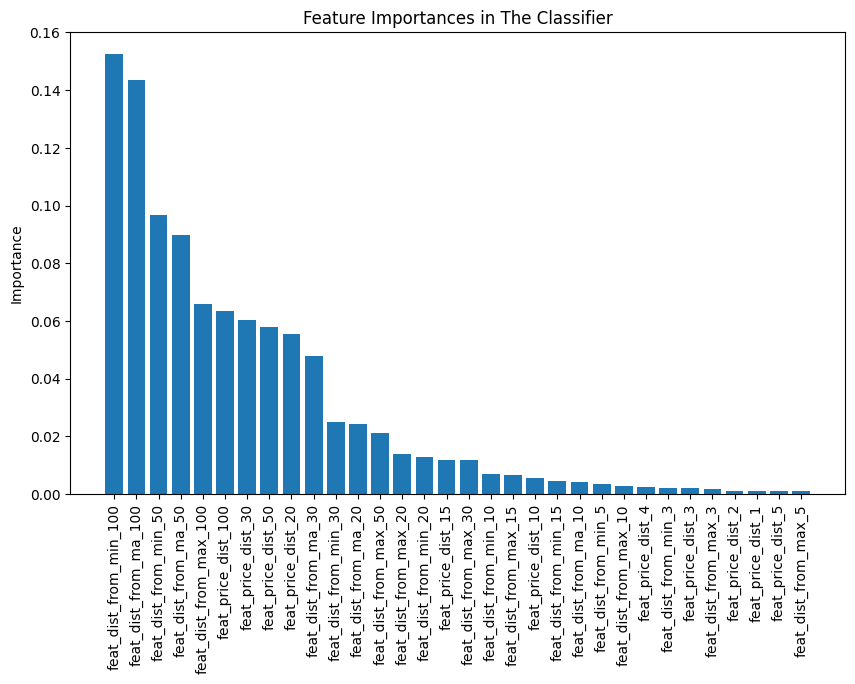

In [13]:
feature_importances = clf.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances in The Classifier")
plt.bar(range(x_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(x_train.shape[1]), x_train.columns[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.show()

In [14]:
import numpy as np

df_test['rf_pred'] = (clf.predict_proba(x_test)[:, 1] > 0.8).astype(int)

fig = px.scatter(
    df_test,
    x='Date',
    y='Close',
    color='rf_pred',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Testing Set',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

In [15]:
df_test['rf_signal'] = df_test['rf_pred'].shift(1)
df_test['equity_rf'] = np.cumprod(1+df_test['rf_signal']*df_test['pct_change'])

fig = go.Figure()

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_buy_and_hold'], name='Buy and Hold')
)

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_cluster'], name='Clustering')
)

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_rf'], name='Random Forest')
)

fig.update_layout(
    title_text='Clustering & RF Backtest',
    legend={'x': 0, 'y':-0.05, 'orientation': 'h'},
    xaxis={'title': 'Date'},
    yaxis={'title': 'Multiple from Initial Investment'}
)

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [16]:
def get_max_drawdown(col):
    drawdown = col/col.cummax()-1
    return 100*drawdown.min()

def calculate_cagr(col, n_years):
    cagr = (col.values[-1]/col.values[0])**(1/n_years)-1
    return 100*cagr

print('Maximum Drawdown Buy and Hold:', get_max_drawdown(df_test['equity_buy_and_hold']))
print('Maximum Drawdown Clustering:', get_max_drawdown(df_test['equity_cluster']))
print('Maximum Drawdown Random Forest:', get_max_drawdown(df_test['equity_rf']))

print('')

n_years = (df_test['Date'].max()-df_test['Date'].min()).days/365.25

print('CAGR Buy and Hold:', calculate_cagr(df_test['equity_buy_and_hold'].dropna(), n_years))
print('CAGR Clustering:', calculate_cagr(df_test['equity_cluster'].dropna(), n_years))
print('CAGR Random Forest:', calculate_cagr(df_test['equity_rf'].dropna(), n_years))

Maximum Drawdown Buy and Hold: -16.46593406030692
Maximum Drawdown Clustering: -5.976727563499495
Maximum Drawdown Random Forest: -5.288130987925199

CAGR Buy and Hold: 11.195522029475802
CAGR Clustering: 7.543392872282029
CAGR Random Forest: 5.721697261700021
